In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


In [17]:

# Function to parse data from a file
def parse_data(file_path):
    sequences = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            cleaned_line = line.strip()
            if cleaned_line in {"end", "<end>"}:
                sequences.append("end")
                labels.append("end")
            elif len(cleaned_line.split()) == 2:
                parts = cleaned_line.split()
                sequences.append(parts[0])  # Amino acid
                labels.append(parts[1])  # Secondary structure label
            else:
                continue  # Skip any malformed lines
    return sequences, labels

# Function to encode sequences
def encode_sequences(sequences):
    amino_acid_mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, 'end': 20}
    encoded_seqs = np.zeros((len(sequences), 21))
    for idx, amino_acid in enumerate(sequences):
        encoded_seqs[idx, amino_acid_mapping[amino_acid]] = 1
    return encoded_seqs

# Function to encode labels
def encode_labels(labels):
    label_mapping = {'e': 0, 'h': 1, '_': 2, 'end': 3}
    encoded_labels = np.zeros((len(labels), 3))  # No need for encoding 'end'
    for idx, label in enumerate(labels):
        if label != 'end':
            encoded_labels[idx, label_mapping[label]] = 1
    return encoded_labels

# Load and process training and test data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")

eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)


In [18]:

# Function to create sliding windows
def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows

# Prepare windowed input for model
windowed_input_train = create_sliding_windows(np.array(eseq_train))
windowed_input_test = create_sliding_windows(np.array(eseq_test))

def build_first_network(input_shape):
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Hidden layer with 40 units
        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=SGD(),  # Stochastic gradient descent optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
def build_second_network():
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(3,)),  # Input shape matches the output of the first network
        Dense(3, activation='softmax')  # Same output configuration as the first network
    ])
    model.compile(optimizer=SGD(),  # Using the same optimizer as the first network
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
def train_cascade(first_model, second_model, X_train, y_train, X_test, y_test):
    # Train the first model and save the history
    history1 = first_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    # Generate intermediate outputs from the first model
    intermediate_output = first_model.predict(X_train)
    
    # Train the second model using the outputs of the first model as inputs, and save the history
    history2 = second_model.fit(intermediate_output, y_train, epochs=50, validation_data=(first_model.predict(X_test), y_test))
    
    return history1, history2



In [19]:
X_train = windowed_input_train
y_train = elab_train
X_test = windowed_input_test
y_test = elab_test

# Define and train models
first_network = build_first_network(input_shape=X_train.shape[1])
second_network = build_second_network()

# Train both models and get their histories
history1, history2 = train_cascade(first_network, second_network, X_train, y_train, X_test, y_test)

# Evaluate models
intermediate_output_test = first_network.predict(X_test)
test_loss, test_accuracy = second_network.evaluate(intermediate_output_test, y_test)
print("Test accuracy:", test_accuracy)

Epoch 1/50
569/569 [==============================] - 1s 2ms/step - loss: 1.0033 - accuracy: 0.5376 - val_loss: 1.0009 - val_accuracy: 0.5440
Epoch 2/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9939 - accuracy: 0.5423 - val_loss: 0.9955 - val_accuracy: 0.5440
Epoch 3/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9877 - accuracy: 0.5423 - val_loss: 0.9919 - val_accuracy: 0.5440
Epoch 4/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9818 - accuracy: 0.5423 - val_loss: 0.9848 - val_accuracy: 0.5440
Epoch 5/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9758 - accuracy: 0.5423 - val_loss: 0.9832 - val_accuracy: 0.5440
Epoch 6/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9698 - accuracy: 0.5423 - val_loss: 0.9769 - val_accuracy: 0.5440
Epoch 7/50
569/569 [==============================] - 1s 2ms/step - loss: 0.9637 - accuracy: 0.5418 - val_loss: 0.9695 - val_accuracy: 0.5440
Epoch 

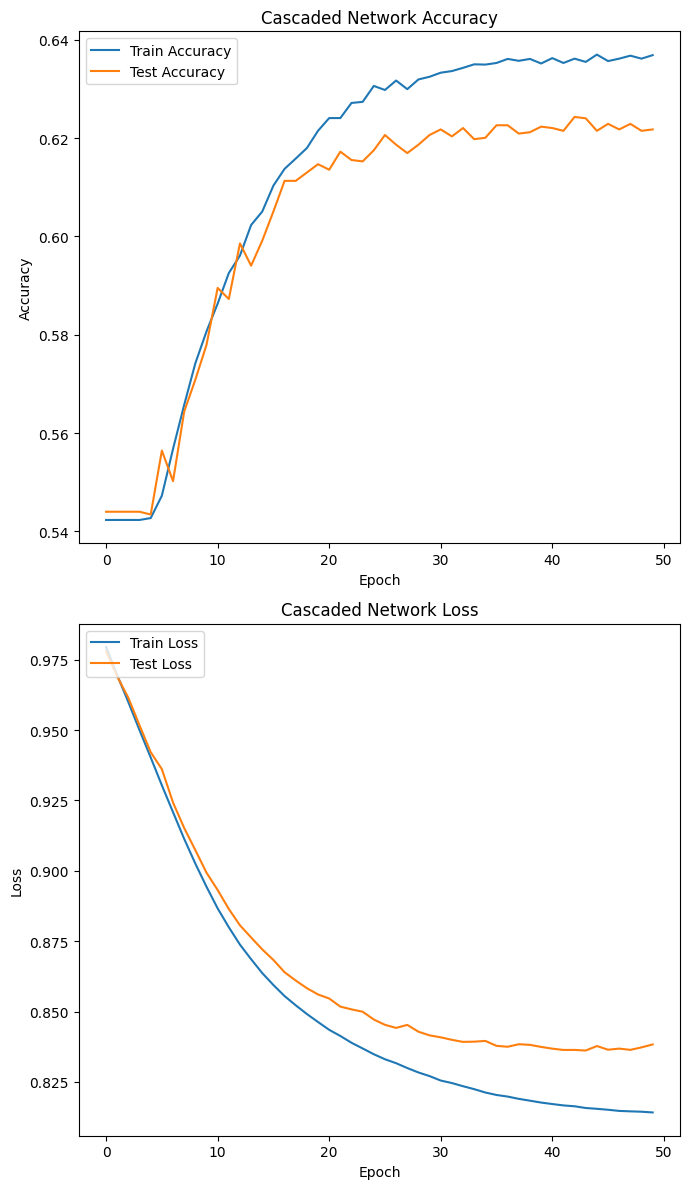

In [22]:

plt.figure(figsize=(7, 12))  # Adjusted figure size for vertical layout

# Subplot for the accuracy of second model
plt.subplot(2, 1, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Test Accuracy')
plt.title('Cascaded Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Subplot for the loss of second model
plt.subplot(2, 1, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('Cascaded Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

111/111 [==============================] - 0s 718us/step


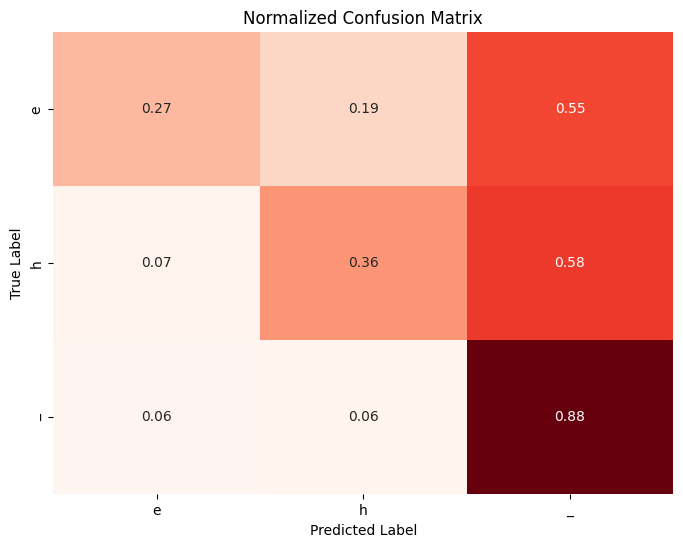

In [23]:
y_pred = second_network.predict(intermediate_output_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Use the encoded labels for y_test

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Reds', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Function to create sliding windows
def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size] for i in range(len(encoded_seqs))])
    return windows

# Assuming the presence of functions parse_data, encode_sequences, and encode_labels
# Load and process training data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
windowed_input_train = create_sliding_windows(np.array(eseq_train), window_size=13)

# Load and process testing data
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)
windowed_input_test = create_sliding_windows(np.array(eseq_test), window_size=13)

# Function to build the second model (cascade)
def build_second_model(input_shape):
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Input shape matches the output of the first network
        Dense(3, activation='softmax')  # Same output configuration as the first network
    ])
    model.compile(optimizer=Adam(),  # Using Adam optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming the presence of the train_cascade function

# Build the first model (Convolutional Neural Network)
def build_improved_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(input_shape[0], input_shape[1]),
               kernel_regularizer=l2(0.01)),  # Single Conv1D layer with increased filters and L2 regularization
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(40, activation='sigmoid', kernel_regularizer=l2(0.01)),  # L2 regularization on Dense layer
        Dropout(0.3),  # Dropout to prevent overfitting
        Dense(3, activation='softmax')
    ])
    optim = Adam(learning_rate=0.0001)  # Optimizer with a conservative learning rate
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the cascade architecture
def build_cascade_model(first_model, second_model):
    # Train the first model
    history1 = first_model.fit(windowed_input_train, elab_train, epochs=25, validation_data=(windowed_input_test, elab_test), batch_size=32)
    
    # Generate intermediate outputs from the first model
    intermediate_output = first_model.predict(windowed_input_train)
    
    # Train the second model using the outputs of the first model
    history2 = second_model.fit(intermediate_output, elab_train, epochs=25, validation_data=(first_model.predict(windowed_input_test), elab_test), batch_size=32)
    
    return history1, history2

# Build and train both models
first_model = build_improved_model(windowed_input_train.shape[1:])
second_model = build_second_model(first_model.output_shape[1])
history1, history2 = build_cascade_model(first_model, second_model)

# Evaluate the cascade architecture
intermediate_output_test = first_model.predict(windowed_input_test)
test_loss, test_accuracy = second_model.evaluate(intermediate_output_test, elab_test)
print("Test accuracy:", test_accuracy)


Epoch 1/25
569/569 [==============================] - 2s 3ms/step - loss: 1.8165 - accuracy: 0.5258 - val_loss: 1.6007 - val_accuracy: 0.5443
Epoch 2/25
569/569 [==============================] - 1s 2ms/step - loss: 1.4585 - accuracy: 0.5620 - val_loss: 1.3212 - val_accuracy: 0.5808
Epoch 3/25
569/569 [==============================] - 1s 2ms/step - loss: 1.2481 - accuracy: 0.5802 - val_loss: 1.1624 - val_accuracy: 0.5966
Epoch 4/25
569/569 [==============================] - 1s 3ms/step - loss: 1.1239 - accuracy: 0.5915 - val_loss: 1.0647 - val_accuracy: 0.6170
Epoch 5/25
569/569 [==============================] - 1s 2ms/step - loss: 1.0445 - accuracy: 0.6019 - val_loss: 1.0041 - val_accuracy: 0.6187
Epoch 6/25
569/569 [==============================] - 1s 2ms/step - loss: 0.9956 - accuracy: 0.6049 - val_loss: 0.9676 - val_accuracy: 0.6184
Epoch 7/25
569/569 [==============================] - 1s 2ms/step - loss: 0.9591 - accuracy: 0.6074 - val_loss: 0.9425 - val_accuracy: 0.6249
Epoch 

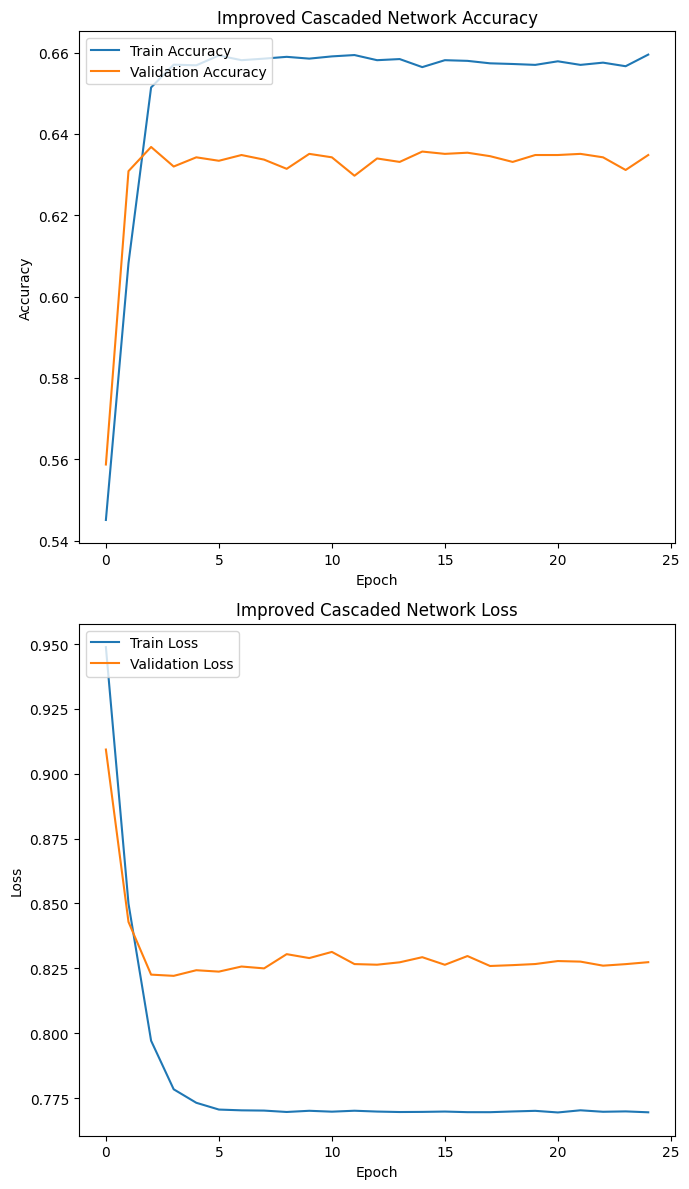

In [25]:
# Set up a figure to host two subplots vertically
plt.figure(figsize=(7, 12))  # Adjusted figure size for vertical layout

# Subplot for the accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot (top)
plt.plot(history2.history['accuracy'], label='Train Accuracy')  # Use history2 for the second model
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')  # Use history2 for the second model
plt.title('Improved Cascaded Network Accuracy')  # Update the title
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Subplot for the loss
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot (bottom)
plt.plot(history2.history['loss'], label='Train Loss')  # Use history2 for the second model
plt.plot(history2.history['val_loss'], label='Validation Loss')  # Use history2 for the second model
plt.title('Improved Cascaded Network Loss')  # Update the title
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


111/111 [==============================] - 0s 782us/step


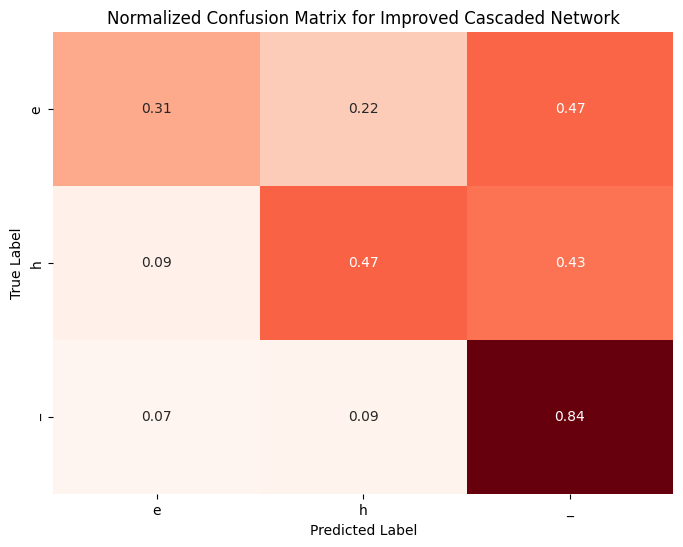

In [26]:
# Predict using the second network (Improved Cascaded Network)
y_pred = second_network.predict(intermediate_output_test)  # Use intermediate_output_test from the cascade architecture
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(elab_test, axis=1)  # Use the encoded labels for elab_test

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Reds', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix for Improved Cascaded Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [27]:
#Test on unseen data sheets
get_Titles ={
  "ACC": "Q5UNT5", 
  "ACC_entry": "YR681_MIMIV", 
  "ASAquick_normscore": "0.680,0.413,0.465,0.261,0.441,0.277,0.459,0.387,0.531,0.385,0.117,0.357,0.483,0.183,0.198,0.313,0.486,0.314,0.148,0.317,0.343,0.371,0.126,0.102,0.383,0.421,0.200,0.159,0.466,0.449,0.164,0.173,0.158,0.148,0.066,0.139,0.192,0.164,0.209,0.400,0.274,0.376,0.232,0.330,0.066,0.114,0.152,0.187,0.137,0.223,0.445,0.309,0.440,0.437,0.187,0.258,0.420,0.157,0.230,0.132,0.231,0.104,0.128,0.411,0.450,0.376,0.216,0.438,0.241,0.138,0.198,0.075,0.119,0.083,0.072,0.115,0.228,0.123,0.148,0.299,0.423,0.376,0.180,0.389,0.490,0.404,0.377,0.110,0.269,0.419,0.147,0.128,0.293,0.350,0.375,0.364,0.457,0.524,0.305,0.304,0.305,0.216,0.175,0.154,0.186,0.157,0.099,0.336,0.495,0.238,0.507,0.433,0.381,0.421,0.234,0.117,0.133,0.080,0.066,0.150,0.248,0.119,0.384,0.454,0.214,0.390,0.252,0.247,0.095,0.344,0.136,0.097,0.239,0.325,0.137,0.152,0.418,0.394,0.156,0.442,0.257,0.212,0.299,0.490,0.445,0.192,0.422,0.463,0.351,0.431,0.755", 
  "ASAquick_rawscore": "152.4,108.6,80.0,52.5,70.1,55.6,88.6,60.1,103.5,85.9,23.6,80.2,107.8,36.8,34.1,53.9,108.3,48.7,29.2,61.8,77.1,63.8,24.8,20.0,90.4,99.4,52.5,38.1,90.9,100.0,25.4,22.3,31.1,38.9,13.3,21.6,50.6,32.4,21.7,78.1,72.2,72.5,39.9,64.3,11.0,22.5,30.5,32.2,32.8,23.2,104.9,53.1,120.6,84.2,37.6,44.3,99.2,37.6,54.4,25.9,29.8,18.0,33.7,97.0,106.1,103.0,56.8,103.4,63.4,33.1,38.7,14.8,23.4,10.7,14.5,32.9,44.4,21.3,29.2,57.7,81.6,64.6,36.2,66.8,109.3,62.6,73.6,21.7,41.8,98.8,28.9,25.3,50.4,67.5,64.6,71.0,72.6,117.8,80.2,59.3,48.5,56.8,39.3,37.0,32.3,37.6,20.0,53.4,96.5,47.8,119.6,68.9,65.6,99.4,45.7,23.1,26.1,13.8,12.9,29.2,67.9,23.5,105.3,88.5,43.0,76.1,66.2,55.3,18.7,66.4,27.3,19.1,41.0,62.7,27.0,30.0,94.1,93.0,26.8,104.2,51.7,51.0,67.0,109.2,86.7,24.7,67.1,90.3,70.5,113.3,169.2", 
  "DFLpredScore": "0.095,0.094,0.085,0.088,0.086,0.078,0.089,0.096,0.095,0.124,0.118,0.120,0.134,0.132,0.131,0.118,0.100,0.082,0.078,0.078,0.087,0.088,0.106,0.093,0.073,0.065,0.052,0.064,0.047,0.037,0.036,0.046,0.048,0.053,0.064,0.080,0.096,0.078,0.073,0.073,0.066,0.088,0.087,0.101,0.099,0.111,0.118,0.113,0.089,0.090,0.079,0.062,0.055,0.053,0.055,0.054,0.044,0.052,0.041,0.041,0.034,0.029,0.032,0.030,0.024,0.026,0.026,0.031,0.040,0.040,0.033,0.038,0.044,0.053,0.046,0.058,0.067,0.093,0.138,0.111,0.152,0.180,0.162,0.157,0.160,0.143,0.146,0.184,0.194,0.189,0.156,0.185,0.188,0.172,0.160,0.130,0.153,0.127,0.122,0.153,0.188,0.162,0.141,0.147,0.142,0.117,0.129,0.124,0.095,0.087,0.082,0.084,0.087,0.067,0.078,0.096,0.080,0.080,0.079,0.080,0.061,0.058,0.060,0.045,0.057,0.066,0.054,0.054,0.049,0.041,0.052,0.043,0.035,0.035,0.029,0.033,0.042,0.051,0.062,0.079,0.084,0.069,0.060,0.067,0.077,0.073,0.081,0.068,0.077,0.083,0.096", 
  "DRNApredDNAscore": "0.295,0.328,0.317,0.097,0.157,0.098,0.204,0.467,0.440,0.116,0.104,0.475,0.120,0.100,0.487,0.675,0.192,0.761,0.255,0.726,0.695,0.745,0.193,0.216,0.780,0.749,0.708,0.390,0.721,0.204,0.642,0.202,0.180,0.595,0.142,0.727,0.677,0.227,0.604,0.866,0.874,0.662,0.872,0.841,0.156,0.284,0.190,0.859,0.633,0.706,0.865,0.883,0.892,0.600,0.171,0.808,0.824,0.418,0.768,0.224,0.186,0.224,0.722,0.746,0.774,0.805,0.841,0.822,0.733,0.322,0.513,0.143,0.136,0.151,0.106,0.490,0.546,0.186,0.135,0.291,0.276,0.543,0.127,0.625,0.200,0.747,0.622,0.172,0.726,0.770,0.195,0.204,0.743,0.486,0.756,0.808,0.463,0.776,0.844,0.769,0.345,0.688,0.553,0.266,0.180,0.205,0.101,0.194,0.561,0.128,0.707,0.332,0.693,0.749,0.699,0.202,0.195,0.183,0.195,0.685,0.771,0.250,0.840,0.793,0.139,0.609,0.639,0.540,0.157,0.289,0.103,0.142,0.505,0.252,0.147,0.168,0.560,0.586,0.594,0.566,0.117,0.251,0.539,0.153,0.456,0.150,0.219,0.536,0.126,0.556,0.426", 
  "DRNApredRNAscore": "0.042,0.041,0.041,0.040,0.038,0.038,0.038,0.038,0.030,0.030,0.025,0.025,0.025,0.025,0.025,0.026,0.025,0.026,0.025,0.026,0.026,0.026,0.025,0.025,0.026,0.026,0.026,0.026,0.026,0.026,0.026,0.026,0.022,0.022,0.021,0.022,0.022,0.021,0.022,0.022,0.022,0.021,0.022,0.021,0.021,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.020,0.021,0.021,0.021,0.021,0.020,0.024,0.024,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.024,0.024,0.024,0.024,0.025,0.029,0.032,0.031,0.027,0.027,0.027,0.027,0.026,0.026,0.026,0.027,0.027,0.026,0.025,0.025,0.025,0.023,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.024,0.027,0.029,0.029,0.028,0.029,0.029,0.029,0.027,0.027,0.023,0.023,0.023,0.023,0.023,0.024,0.023,0.024,0.024,0.023,0.024,0.024,0.024,0.023,0.023,0.025,0.033,0.034,0.034,0.035,0.035,0.036,0.036,0.036,0.036,0.035,0.036,0.036,0.035,0.036,0.035,0.036,0.036,0.035,0.036,0.036", 
  "DisoDNAscore": "0.059,0.061,0.046,0.051,0.051,0.051,0.042,0.049,0.051,0.045,0.046,0.042,0.046,0.047,0.060,0.079,0.070,0.060,0.047,0.045,0.060,0.060,0.061,0.067,0.067,0.074,0.070,0.084,0.081,0.070,0.074,0.074,0.074,0.063,0.067,0.052,0.041,0.044,0.044,0.054,0.084,0.075,0.078,0.077,0.086,0.082,0.097,0.089,0.114,0.109,0.129,0.145,0.135,0.174,0.245,0.247,0.228,0.275,0.261,0.261,0.222,0.179,0.183,0.178,0.184,0.130,0.116,0.093,0.111,0.085,0.084,0.079,0.079,0.084,0.054,0.045,0.036,0.040,0.033,0.048,0.057,0.066,0.065,0.064,0.060,0.050,0.071,0.082,0.072,0.062,0.062,0.057,0.058,0.048,0.050,0.051,0.048,0.055,0.047,0.044,0.044,0.043,0.042,0.056,0.049,0.050,0.059,0.062,0.062,0.059,0.073,0.075,0.087,0.076,0.093,0.078,0.085,0.091,0.093,0.106,0.106,0.083,0.082,0.083,0.065,0.075,0.075,0.096,0.091,0.116,0.136,0.108,0.119,0.093,0.093,0.094,0.106,0.101,0.093,0.085,0.095,0.093,0.093,0.095,0.097,0.096,0.096,0.097,0.064,0.065,0.038", 
  "DisoPROscore": "0.468,0.419,0.393,0.405,0.398,0.370,0.362,0.355,0.306,0.319,0.362,0.406,0.421,0.418,0.407,0.410,0.357,0.413,0.372,0.398,0.419,0.422,0.418,0.434,0.449,0.413,0.390,0.396,0.370,0.359,0.339,0.334,0.353,0.334,0.325,0.314,0.300,0.263,0.270,0.258,0.251,0.272,0.263,0.228,0.215,0.204,0.206,0.203,0.203,0.213,0.207,0.211,0.224,0.231,0.238,0.234,0.231,0.218,0.215,0.240,0.264,0.269,0.268,0.273,0.276,0.258,0.257,0.263,0.271,0.266,0.269,0.245,0.253,0.251,0.221,0.215,0.215,0.213,0.211,0.205,0.218,0.257,0.262,0.257,0.264,0.274,0.268,0.284,0.272,0.296,0.309,0.332,0.328,0.319,0.296,0.315,0.309,0.315,0.331,0.345,0.357,0.371,0.382,0.375,0.394,0.381,0.400,0.409,0.436,0.421,0.409,0.450,0.428,0.412,0.373,0.357,0.337,0.303,0.265,0.233,0.238,0.231,0.211,0.208,0.196,0.200,0.206,0.204,0.190,0.189,0.194,0.210,0.201,0.222,0.286,0.291,0.331,0.309,0.358,0.348,0.349,0.346,0.348,0.328,0.297,0.294,0.305,0.305,0.322,0.342,0.330", 
  "DisoRNAscore": "0.003,0.003,0.003,0.003,0.003,0.004,0.004,0.006,0.005,0.005,0.006,0.008,0.007,0.008,0.008,0.007,0.007,0.008,0.010,0.012,0.009,0.009,0.011,0.013,0.011,0.012,0.012,0.015,0.011,0.011,0.014,0.012,0.015,0.013,0.014,0.018,0.021,0.022,0.025,0.026,0.028,0.027,0.038,0.044,0.042,0.047,0.050,0.056,0.073,0.083,0.093,0.092,0.089,0.092,0.077,0.081,0.073,0.075,0.079,0.069,0.072,0.064,0.061,0.069,0.069,0.056,0.054,0.048,0.046,0.039,0.045,0.051,0.044,0.038,0.037,0.044,0.041,0.045,0.047,0.060,0.046,0.045,0.046,0.060,0.056,0.046,0.045,0.043,0.044,0.040,0.044,0.045,0.042,0.047,0.044,0.049,0.047,0.050,0.053,0.057,0.045,0.046,0.041,0.034,0.042,0.030,0.029,0.026,0.027,0.034,0.029,0.028,0.026,0.030,0.032,0.023,0.026,0.024,0.025,0.021,0.022,0.025,0.034,0.029,0.033,0.030,0.026,0.026,0.029,0.027,0.030,0.027,0.021,0.018,0.017,0.021,0.020,0.019,0.016,0.020,0.028,0.025,0.027,0.027,0.025,0.019,0.018,0.018,0.014,0.012,0.008", 
  "MMseq2_conservation_level": "9,9,1,1,6,4,0,0,2,1,1,2,1,3,4,1,0,2,8,3,1,1,3,1,0,1,9,1,7,1,6,4,4,9,3,1,9,4,5,0,9,4,1,0,7,2,3,0,2,5,5,1,1,6,1,4,2,2,2,1,1,1,6,5,2,1,9,4,1,8,8,1,4,1,1,9,1,0,3,1,3,4,1,0,4,2,3,4,0,2,0,6,2,1,0,5,7,1,3,5,3,4,3,6,1,2,0,8,4,1,1,4,1,1,0,1,0,4,1,7,1,0,2,3,2,1,9,8,0,4,3,1,4,4,1,1,1,3,6,2,3,2,2,4,4,0,6,6,2,9,9", 
  "MMseq2_conservation_score": "3.52,3.39,1.80,1.86,2.73,2.40,1.31,1.34,1.92,1.52,1.67,1.92,1.65,2.19,2.42,1.46,1.38,1.98,3.05,2.29,1.87,1.76,2.21,1.68,1.36,1.85,3.33,1.77,2.96,1.73,2.71,2.38,2.45,3.32,2.18,1.81,3.32,2.47,2.58,1.43,3.33,2.54,1.67,1.24,2.94,2.02,2.20,1.22,1.95,2.59,2.57,1.45,1.77,2.74,1.75,2.44,1.92,1.92,1.90,1.87,1.69,1.77,2.76,2.56,1.91,1.70,3.39,2.35,1.76,2.99,2.97,1.83,2.45,1.88,1.88,4.34,1.79,1.37,2.21,1.57,2.25,2.55,1.79,1.00,2.37,1.93,2.33,2.46,0.92,2.03,1.26,2.81,1.95,1.84,1.35,2.57,2.95,1.81,2.21,2.57,2.34,2.53,2.22,2.78,1.69,1.92,1.37,3.03,2.52,1.81,1.78,2.42,1.69,1.50,1.42,1.84,1.32,2.37,1.53,2.96,1.49,1.00,2.12,2.24,2.04,1.72,3.40,2.97,1.26,2.43,2.20,1.88,2.38,2.42,1.84,1.84,1.73,2.32,2.83,1.92,2.20,2.16,1.97,2.37,2.55,1.41,2.84,2.79,2.02,3.31,3.60", 
  "MMseqs2_pssm": "Pos Cns A C D E F G H I K L M N P Q R S T V W Y,0 M -1 -1 -4 -3 0 -2 -1 0 -2 1 7 -3 -2 -1 -1 -3 -2 0 0 -1,1 Y -2 -2 -4 -3 2 -3 1 -2 -3 -1 -2 -4 -3 -2 -2 -3 -3 -1 2 8,2 T 0 0 -3 -2 -1 -2 -2 3 -2 0 0 -2 -2 -2 -2 -1 4 0 -1 -2,3 L 0 -1 -3 -2 0 -2 -2 0 -2 4 0 -3 -2 -2 -2 1 -1 0 -1 -2,4 P -1 7 -3 -2 -3 -2 -2 -3 -2 -3 -3 -3 7 -2 -2 -2 -2 -2 -2 -3,5 P -1 -2 -1 -2 -1 -1 -1 -1 -2 2 -1 2 5 -2 -2 -2 -2 -1 -2 -2,6 K 0 -2 3 0 -3 -1 -1 -3 2 -3 -3 -1 -1 0 0 2 -1 -3 -2 -2,7 E 0 -2 -1 3 -3 -1 -1 -3 2 -3 -2 -1 -1 0 0 2 -1 -2 -2 -3,8 S 0 -1 0 -1 -3 0 -1 -3 -1 -3 -2 3 -1 -1 -1 4 0 -2 -2 -3,9 D -1 -2 3 3 -3 -1 -1 -2 -1 -3 -3 -1 -1 0 -1 -1 2 -2 -2 -3,10 I -2 -1 -4 -4 0 -3 -3 4 -4 3 0 -5 -3 -4 -3 -3 -2 1 -1 -2,11 Q -1 -2 3 0 -2 -1 -1 -1 -1 -1 4 -1 -2 4 -1 -2 -2 -1 -2 -2,12 R -1 -3 -1 3 -3 4 -1 -4 0 -3 -3 -2 -2 0 4 -2 -2 -3 -2 -3,13 L -2 -1 -4 -4 0 -3 -3 0 -3 5 0 -4 -3 -3 -2 -3 -2 0 -1 -2,14 N -1 -2 0 -1 -3 0 0 -3 -1 -3 -2 5 -2 -1 -1 0 3 -2 -3 -3,15 K -1 -2 -1 -1 -3 -1 -1 -3 3 -3 -2 3 -1 0 0 0 3 -2 -2 -3,16 S 0 -2 0 3 -3 -1 -1 -3 3 -3 -2 -1 -1 0 0 2 -1 -2 -2 -3,17 F -1 -2 -2 -2 4 -1 0 -2 -2 -1 -1 -2 -2 -2 -2 2 -1 -1 0 4,18 Y -2 -2 -4 -3 1 -3 0 2 -3 0 -1 -3 -3 -2 -2 -3 -2 0 1 6,19 D -2 -3 5 0 -4 -1 -1 -4 -1 -4 -3 4 -2 -1 -1 -1 -1 -4 -4 -4,20 Q -2 -3 4 0 -3 -1 0 -4 -1 -3 -2 3 -2 4 0 -1 -1 -3 -3 -3,21 N -2 -2 4 0 -3 -1 -1 -3 -1 -3 -2 3 -2 -1 -1 0 3 -2 -3 -3,22 I -2 -1 -4 -3 0 -3 -3 4 -3 0 5 -4 -3 -2 -3 -3 -1 1 -2 -2,23 I -2 -1 -4 -4 0 -4 -3 4 -3 3 0 -5 -3 -3 -3 -3 -2 1 -2 -2,24 S -1 -2 -1 -1 -3 -1 -1 -3 2 -3 -2 3 -1 0 0 2 0 -2 -3 -3,25 D -2 -3 4 3 -4 -2 -1 -3 2 -3 -3 -1 -1 0 0 -1 -2 -3 -3 -3,26 Y -2 -2 -4 -3 2 -3 0 -2 -3 -1 -2 -3 -2 -2 -2 -3 -2 -1 2 7,27 Q -1 -3 -2 0 4 -2 -1 -2 3 -1 -1 -2 -1 4 0 -1 -2 -2 0 0,28 N -2 -2 0 -1 -3 0 0 -4 -1 -4 -3 6 -2 -1 -1 0 -1 -3 -3 -3,29 M -1 -2 -1 3 -1 -3 -2 2 -2 0 4 -3 -2 0 -2 -2 -2 0 -2 -2,30 P 0 -2 -2 -1 0 -2 -1 -3 -1 -3 -2 -2 6 -1 -2 2 -1 -2 0 4,31 A 5 0 -2 -1 -3 0 -2 -2 -1 -2 -2 -3 0 -1 -2 0 -1 0 -2 -3,32 I -2 -1 -3 -4 0 -4 -4 5 -4 0 0 -4 -2 -3 -3 -3 -1 1 -2 -2,33 Y -2 -2 -4 -2 2 -3 0 -2 -3 -1 -2 -3 -2 -2 -2 -2 -3 -1 2 7,34 L -2 -1 -4 -3 0 -4 -3 0 -3 5 1 -5 -3 -3 -2 -3 -2 0 -1 -2,35 A 4 0 -2 -1 -3 0 -2 -2 -2 -2 -2 -2 0 -1 -1 3 0 -1 -2 -3,36 Y -2 -2 -4 -2 2 -3 0 -2 -3 -1 -2 -3 -2 -2 -2 -2 -2 -1 2 7,37 I -2 -1 -4 -3 -1 -4 -4 5 -4 0 0 -4 -2 -3 -3 -3 -2 1 -2 -2,38 G 0 -2 -2 -2 -4 7 -3 -4 -3 -4 -3 -1 -2 -2 -3 -1 -2 -4 -2 -4,39 K -1 -3 0 3 -4 -1 0 -4 2 -3 -2 3 -1 0 0 0 -1 -3 -3 -3,40 Y -2 -2 -4 -2 2 -3 0 -2 -3 -2 -2 -3 -3 -2 -2 -2 -2 -1 2 7,41 D -2 -3 6 0 -4 -1 -1 -4 -2 -4 -3 4 -1 0 -1 0 -1 -4 -4 -4,42 N -1 -2 0 -1 -3 4 -1 -3 -2 -3 -2 4 -1 -1 -2 0 3 -2 -2 -3,43 K -2 -2 -1 -1 -2 -1 -1 2 2 -1 -1 3 -2 -1 0 -1 -1 0 -3 -3,44 H -2 7 -2 -1 -2 -2 7 -3 -3 -2 -2 -1 -2 -1 -1 -1 -2 -2 -2 0,45 I -2 -1 -3 -3 -1 -3 -3 4 -3 0 4 -3 -2 -2 -3 -3 -1 1 -2 -2,46 L -2 -1 -4 -3 0 -3 -3 0 -4 5 0 -4 -3 -3 -3 -3 -2 0 -1 -2,47 K -1 -1 -1 -1 -2 -2 -2 2 2 -1 -1 -1 -1 -1 -1 0 3 0 -2 -3,48 Y -2 -1 -3 -3 4 -3 -1 2 -4 0 -1 -3 -3 -3 -3 -3 -2 0 0 4,49 G 0 -2 -2 -3 -4 7 -3 -4 -3 -4 -3 -1 -2 -2 -3 -1 -2 -4 -2 -4,50 K -1 -3 -1 0 -4 -1 -1 -3 5 -3 -2 -1 -1 0 1 -1 -1 -3 -3 -3,51 S 0 -1 0 -1 -3 0 -1 -2 -2 -3 -2 3 -1 -1 -2 3 3 -2 -3 -3,52 N -2 -3 4 0 -4 -1 -1 -4 -1 -3 -3 4 -1 0 3 0 -1 -3 -3 -3,53 D -2 -3 6 0 -4 -1 -2 -4 2 -4 -3 0 -1 0 -1 0 -2 -3 -4 -4,54 L -2 -1 -4 -3 4 -3 -3 0 -4 4 0 -4 -3 -3 -3 -3 -2 0 0 0,55 T 0 0 -2 -2 -2 -2 -3 0 -2 -1 -1 -2 -1 -2 -2 0 5 2 -2 -2,56 K -1 -2 -1 0 -3 -1 -2 -3 4 -2 -2 -1 -1 0 0 0 3 -2 -3 -3,57 R -2 -2 -3 -2 4 -3 0 -2 -1 -1 -1 -2 -2 -1 3 -2 -2 -2 0 4,58 K -1 -3 4 0 -3 -1 -1 -4 4 -3 -3 0 -1 0 0 0 -2 -3 -3 -3,59 L -2 -1 -4 -3 0 -3 -3 2 -4 4 0 -4 -2 -3 -3 -3 -2 0 -2 -2,60 E 2 -1 -1 3 -2 -1 -1 -1 -2 -1 4 -2 -1 0 -1 0 -2 -1 -2 -2,61 Q -1 -2 -2 0 -2 -2 -1 -1 2 -1 -1 -2 -1 4 0 -1 -1 2 -2 -2,62 Y -2 -2 -3 -1 1 -2 6 -3 -3 -2 -2 -2 -2 -1 -2 -2 -3 -2 1 6,63 R -1 -3 -2 0 -3 -2 -1 -4 2 -3 -2 -1 -1 0 5 -1 -2 -3 -3 -2,64 K -1 -2 -1 0 -3 -1 -1 -3 4 -2 -2 -1 -1 0 0 0 3 -2 -3 -2,65 M -2 -1 -3 -2 -1 -2 -1 0 -1 2 4 -2 -2 -1 3 -2 -2 -1 -2 -2,66 Y -2 -2 -4 -3 2 -3 1 -2 -3 -2 -2 -3 -2 -2 -2 -2 -3 -2 2 8,67 K -1 -2 -2 0 -3 -1 5 -3 4 -3 -2 -1 -1 0 0 -1 -2 -3 -2 -1,68 Y -2 -2 3 0 0 -1 0 -3 2 -3 -2 -1 -1 0 0 -1 -2 -3 0 4,69 F -3 -2 -4 -4 7 -3 -1 -1 -5 0 0 -4 -3 -4 -4 -3 -3 -1 0 2,70 N -2 -2 0 -1 -3 0 0 -4 -2 -4 -3 6 -2 -1 -1 0 -1 -3 -3 -2,71 I -1 -1 -4 -3 0 -3 -3 4 -4 0 0 -4 -2 -3 -4 -3 -1 3 -2 -2,72 I -2 -1 -4 -4 0 -3 -3 5 -4 0 0 -4 -2 -3 -3 -3 -1 1 -2 -2,73 K 2 -1 -1 0 -3 0 -1 -3 4 -3 -2 -1 0 0 0 0 -1 -2 -2 -2,74 I -2 -1 -4 -4 0 -3 -3 4 -4 2 0 -4 -2 -3 -3 -3 -2 1 -2 -2,75 W -3 -2 -5 -3 0 -2 -3 -3 -4 -2 -2 -4 -3 -2 -3 -4 -4 -4 12 1,76 E -2 -3 4 3 -3 -1 0 -4 -1 -4 -3 3 -1 0 -1 -1 -2 -3 -3 -3,77 T -1 0 -3 -2 -1 -2 -3 3 -3 0 0 -3 -2 -2 -3 -1 3 2 -2 -2,78 I -2 -1 -4 -3 0 -3 -3 4 -3 0 5 -4 -2 -2 -3 -3 -2 1 -2 -1,79 D 3 -1 4 0 -3 0 -1 -3 -2 -3 -2 0 -1 -1 -2 3 -1 -2 -3 -3,80 N -2 -2 4 0 -3 0 0 -4 -2 -4 -3 5 -2 -1 -1 0 -1 -3 -3 -3,81 D -2 -2 5 0 -3 -1 -2 -3 -2 -3 -3 0 -1 -1 -2 0 2 -2 -3 -3,82 L -2 -1 -3 -2 0 -2 -2 0 2 4 0 -3 -2 -1 0 -2 -2 0 -2 -2,83 T 2 0 -2 -2 -2 -1 -2 0 -2 -1 -1 -3 -1 -2 -2 0 2 2 -2 -2,84 E -1 -2 0 5 -2 -2 -1 -2 -1 2 -1 -2 -1 0 -1 -1 -2 -1 -2 -2,85 S 0 -1 -1 0 -3 0 -1 -3 2 -3 -2 -1 -1 0 0 4 0 -2 -2 -2,86 N -1 -2 0 0 -4 0 0 -4 3 -3 -2 5 -1 0 0 0 -1 -3 -3 -3,87 I -2 -1 -4 -4 0 -3 -3 5 -4 0 0 -4 -3 -3 -3 -3 -2 1 -2 -2,88 K -1 -1 -2 -1 -2 -1 -1 2 2 -1 -1 -2 -1 0 0 2 -1 0 -2 -2,89 K -1 -2 -1 0 -3 -1 -1 -3 4 -2 -2 -1 -1 0 0 0 2 -2 -2 -2,90 N -1 -1 -1 -2 -1 -2 -1 2 -2 0 0 3 -2 -2 -2 -2 -1 2 -2 -2,91 F -2 -2 -4 -4 6 -3 -2 2 -4 0 0 -4 -3 -4 -3 -3 -3 0 0 1,92 T 2 0 -2 -1 -2 0 -1 -1 -2 -2 -1 -1 -1 -1 -1 0 4 -1 -2 -2,93 S -1 -2 4 0 -3 0 0 -3 -2 -4 -3 3 -2 -1 -1 2 -1 -3 -3 -2,94 K -1 -2 -1 -1 -3 -1 0 -2 2 -3 -2 3 -2 0 0 0 2 -2 -2 -2,95 N -2 -2 0 -1 -3 0 0 -3 2 -3 -2 5 -2 0 0 -1 -1 -3 -3 -2,96 P -1 -2 -3 -2 -2 -2 -2 -1 -3 0 5 -3 7 -2 -2 -2 -2 -1 -2 -2,97 Q 0 -1 -1 0 -3 -1 0 -2 -1 -2 -1 -1 -1 4 0 2 2 -2 -1 -2,98 L -2 -1 -4 -3 1 -3 0 0 -3 3 0 -4 -3 -2 -2 -3 -2 0 0 5,99 N -1 -1 0 -1 -3 0 0 -3 -1 -4 -2 5 -2 -1 -1 2 0 -3 -2 -2,100 P -1 -3 0 3 -3 -2 -1 -3 2 -3 -2 -2 5 0 0 -1 -2 -3 -2 -2,101 Y -1 -1 -2 -1 0 -2 0 -2 2 -2 -2 -2 -2 -1 0 -1 2 -2 0 5,102 Q -1 -2 0 3 0 -2 0 -3 -1 -3 -2 -2 -2 4 -1 -1 -2 -3 0 5,103 F -2 -1 -4 -4 6 -3 -2 0 -4 2 0 -4 -3 -4 -3 -3 -3 -1 0 1,104 G -1 -2 3 -1 -2 4 -2 0 -3 -2 -1 -2 -2 -2 -3 -1 -2 2 -2 -3,105 I -2 -1 -3 -4 4 -3 -2 4 -4 0 0 -4 -3 -3 -3 -3 -2 0 0 0,106 L -1 -1 -3 -2 0 -2 -2 0 2 3 0 -3 -2 -1 0 -2 -2 0 -1 -2,107 C 0 7 -2 -2 -3 -1 -2 -3 -2 -3 -2 -2 5 -2 -2 2 -1 -2 -2 -3,108 N -1 -3 0 0 -3 0 0 -4 2 -4 -2 5 -2 0 0 0 -1 -3 -3 -3,109 Q -1 -2 -1 0 -2 -1 0 -1 -1 1 0 3 -2 4 -1 -1 -1 -1 -2 -2,110 K 3 -2 -2 0 -3 0 -1 -3 4 -3 -2 -2 -1 0 0 0 -1 -2 -2 -3,111 T -1 -1 -2 -2 -2 -2 -2 -1 -2 1 0 -3 5 -2 -2 -1 3 -1 -2 -3,112 K 0 -2 -2 -1 -3 4 -2 -3 2 -3 -2 -1 -1 -1 0 0 3 -2 -2 -3,113 R -1 -3 3 0 -3 -1 -1 -3 3 -3 -2 -1 -2 0 3 -1 -2 -3 -2 -3,114 E -1 -3 0 3 -3 -1 0 -4 2 -4 -2 3 -1 0 0 0 -1 -3 -2 -2,115 I -1 -1 -4 -4 0 -3 -3 4 -3 2 0 -4 -3 -3 -3 -3 -1 1 -1 -2,116 V -1 -1 -4 -3 0 -3 -3 3 -3 2 0 -4 -3 -3 -3 -2 -1 3 -2 -2,117 V 0 -1 -4 -3 -1 -3 -3 1 -3 0 0 -4 -2 -3 -3 -2 -1 5 -2 -2,118 L -1 -1 -4 -3 0 -3 -3 2 -4 3 0 -4 -3 -3 -3 -3 -2 0 -1 -2,119 N -2 -2 0 -1 -3 0 0 -4 -1 -4 -3 6 -2 -1 -1 0 -1 -4 -3 -2,120 E -2 -3 3 3 -3 -1 0 -4 0 -4 -3 0 -1 0 3 -1 -2 -3 -2 -2,121 V -1 -1 -3 -2 -1 -2 -2 2 2 0 0 -3 -1 -1 -1 -2 -1 2 -2 -2,122 N -2 -3 -1 -1 0 -1 0 -3 0 -3 -2 4 -2 0 3 -1 -2 -3 0 5,123 N -2 -3 4 0 -3 0 0 -4 -1 -4 -3 5 -2 -1 -1 0 -1 -4 -3 -2,124 L -2 -1 -4 -3 0 -3 -3 0 -3 4 0 -4 -3 -3 -3 -3 -2 0 -1 -1,125 E -1 -3 0 3 -3 -1 0 -4 0 -4 -2 3 -1 4 0 0 -1 -3 -2 -2,126 Y -2 -2 -4 -3 2 -3 0 -2 -3 -2 -2 -3 -3 -2 -2 -2 -2 -2 2 8,127 C -2 7 -3 -3 4 -2 5 -2 -3 -1 -1 -2 -3 -2 -2 -2 -2 -2 0 1,128 R -2 -1 -3 -3 0 -3 -2 2 -1 2 0 -4 -3 -2 3 -2 -2 0 -1 -2,129 D -2 -3 5 0 -3 0 -1 -4 -1 -4 -3 3 -2 -1 -2 0 -1 -4 -3 -3,130 M -1 -1 -4 -3 0 -3 -3 3 -3 2 5 -4 -3 -2 -3 -3 -2 0 -1 -2,131 I -2 -1 -4 -4 0 -3 -4 4 -3 2 0 -4 -3 -3 -3 -3 -2 1 -2 -2,132 D -1 -2 5 0 -3 -1 -2 -3 -1 -3 -3 0 -1 -1 -2 0 3 -2 -3 -3,133 D -2 -3 5 0 -4 0 -1 -4 -1 -4 -3 3 -1 -1 -2 0 -1 -4 -4 -3,134 I -1 -1 -4 -3 -1 -3 -4 4 -3 0 0 -4 -2 -3 -3 -3 -1 3 -2 -2,135 I -1 -1 -4 -3 -1 -3 -4 4 -3 0 0 -4 -2 -3 -3 -3 -1 3 -2 -2,136 Q -1 -3 0 3 -4 -1 -1 -4 3 -3 -2 -1 -1 4 0 -1 -1 -3 -2 -2,137 K -1 -3 0 0 -4 -1 -1 -3 5 -3 -2 3 -1 0 0 0 -1 -3 -3 -3,138 T 0 -1 -2 -1 -3 -1 -2 -1 -1 -2 -1 -1 -1 -1 -2 0 6 0 -2 -2,139 K -1 -2 -2 0 -3 -1 -2 -2 4 -2 -2 -1 -1 0 0 0 3 -2 -3 -3,140 L -2 -1 -4 -4 0 -3 -4 0 -3 5 0 -5 -3 -3 -3 -3 -2 0 -1 -2,141 P -2 -2 -3 -3 4 -3 -3 -1 -3 2 0 -4 5 -3 -3 -2 -2 -1 -1 0,142 Q -1 -3 -2 0 -3 4 5 -4 -1 -3 -2 -1 -2 4 0 -1 -2 -3 -2 -1,143 E -1 -3 0 5 -4 -1 -1 -4 0 -4 -3 3 -1 0 0 0 -1 -3 -3 -3,144 D -2 -3 6 0 -4 -1 -1 -4 -1 -4 -3 4 -2 -1 -1 0 -1 -4 -4 -3,145 V 3 0 -3 -2 -2 -1 -3 0 -2 0 0 -3 -1 -2 -2 0 -1 3 -2 -2,146 P 0 -1 -1 -1 -3 -1 -2 -3 -1 -3 -2 -1 6 -1 -1 3 0 -2 -3 -3,147 Y -2 -2 0 -1 0 -1 0 -3 -1 -2 -2 4 -2 -1 -1 -1 -1 -2 0 6,148 L -2 -1 -4 -3 0 -3 -3 0 -3 4 1 -4 -3 -3 -2 -3 -2 0 -1 -1,149 Y -2 -2 -4 -2 2 -3 1 -2 -2 -1 -1 -3 -3 -2 -1 -2 -2 -1 2 7,150 H -2 -2 -1 0 -1 -2 8 -3 -1 -3 -2 0 -2 0 0 -1 -2 -3 -2 1", 
  "MoRFchibiScore": "0.739,0.716,0.705,0.704,0.697,0.695,0.648,0.573,0.530,0.538,0.566,0.564,0.586,0.598,0.595,0.589,0.590,0.589,0.630,0.626,0.648,0.702,0.760,0.757,0.752,0.749,0.744,0.745,0.660,0.637,0.634,0.672,0.744,0.738,0.736,0.734,0.731,0.735,0.657,0.631,0.635,0.623,0.633,0.638,0.647,0.659,0.669,0.675,0.678,0.634,0.637,0.637,0.645,0.654,0.704,0.736,0.744,0.763,0.760,0.757,0.750,0.740,0.729,0.718,0.709,0.703,0.702,0.702,0.708,0.715,0.723,0.730,0.737,0.740,0.742,0.743,0.747,0.749,0.751,0.716,0.709,0.676,0.667,0.615,0.600,0.601,0.670,0.724,0.725,0.725,0.728,0.727,0.722,0.676,0.670,0.666,0.669,0.673,0.700,0.702,0.741,0.757,0.760,0.765,0.767,0.765,0.754,0.717,0.641,0.636,0.630,0.630,0.631,0.630,0.642,0.706,0.708,0.707,0.703,0.696,0.691,0.689,0.682,0.663,0.658,0.657,0.657,0.659,0.662,0.660,0.662,0.663,0.637,0.634,0.638,0.636,0.616,0.608,0.599,0.563,0.562,0.563,0.550,0.522,0.491,0.503,0.493,0.493,0.504,0.508,0.494", 
  "Native_disorder": "NULL", 
  "Native_rsa_normscore": "NULL", 
  "Native_rsa_rawscore": "NULL", 
  "Native_secstr": "NULL", 
  "PSIPRED_helix": "0,0,1,0,1,1,2,22,58,71,77,79,79,84,79,86,82,76,80,82,95,95,97,97,94,84,73,55,24,34,23,11,8,16,12,14,14,23,10,5,4,1,1,1,2,2,1,2,2,3,6,5,5,7,12,27,41,55,49,48,55,60,53,48,43,38,35,17,13,18,11,21,15,28,26,30,42,39,34,35,36,37,41,32,28,20,18,18,17,14,16,15,8,5,2,1,1,0,0,0,1,1,1,1,0,0,0,1,1,1,2,1,2,1,2,2,1,2,6,11,11,23,22,10,11,12,12,34,60,71,79,80,91,94,96,92,89,75,64,53,46,36,35,35,19,3,3,3,2,3,0", 
  "PSIPRED_strand": "0,41,47,44,26,4,1,1,1,0,0,0,1,1,2,1,1,1,1,1,0,1,1,2,1,1,2,2,3,4,14,42,65,79,83,74,57,38,33,25,30,20,24,39,67,88,91,84,62,34,21,25,25,18,14,26,31,33,48,51,45,39,44,42,29,23,17,25,59,70,79,78,84,71,71,57,38,30,26,15,5,5,9,12,10,9,11,23,32,40,43,50,48,20,5,2,3,6,12,7,24,55,66,90,92,87,47,19,4,4,5,7,11,16,46,82,95,96,91,66,47,45,29,10,15,30,44,37,27,21,17,15,7,2,1,1,1,1,4,11,19,17,13,5,1,1,1,3,3,3,0", 
  "PTMbinary": "0000000000000000000200000000200000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000010", 
  "ProteinName": "Uncharacterized_protein_R681", 
  "SCRIBERscore": "0.561,0.524,0.423,0.433,0.422,0.384,0.369,0.288,0.308,0.288,0.222,0.315,0.354,0.209,0.234,0.265,0.368,0.275,0.229,0.292,0.323,0.262,0.268,0.213,0.268,0.252,0.262,0.214,0.187,0.187,0.149,0.144,0.173,0.215,0.176,0.192,0.263,0.250,0.203,0.316,0.379,0.266,0.284,0.325,0.170,0.227,0.206,0.225,0.327,0.178,0.256,0.234,0.421,0.265,0.254,0.235,0.247,0.270,0.190,0.144,0.181,0.199,0.217,0.177,0.203,0.372,0.215,0.182,0.375,0.209,0.194,0.190,0.185,0.154,0.171,0.256,0.205,0.196,0.175,0.204,0.247,0.235,0.202,0.204,0.238,0.201,0.212,0.171,0.202,0.234,0.224,0.201,0.230,0.341,0.299,0.290,0.366,0.443,0.463,0.315,0.274,0.367,0.285,0.264,0.200,0.278,0.191,0.271,0.254,0.234,0.219,0.224,0.186,0.173,0.153,0.149,0.144,0.121,0.148,0.134,0.192,0.160,0.377,0.262,0.273,0.359,0.343,0.419,0.308,0.305,0.303,0.251,0.281,0.276,0.218,0.220,0.355,0.336,0.262,0.300,0.302,0.379,0.427,0.381,0.416,0.309,0.458,0.436,0.387,0.456,0.479", 
  "SignalP_score": "0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000", 
  "flDPnn_score": "0.28,0.30,0.30,0.27,0.29,0.27,0.26,0.25,0.26,0.21,0.18,0.17,0.19,0.20,0.17,0.17,0.17,0.15,0.14,0.16,0.13,0.14,0.11,0.11,0.10,0.09,0.10,0.07,0.08,0.08,0.07,0.06,0.06,0.05,0.04,0.05,0.06,0.05,0.04,0.04,0.06,0.05,0.06,0.05,0.05,0.05,0.04,0.05,0.07,0.08,0.07,0.08,0.08,0.12,0.10,0.10,0.13,0.19,0.14,0.12,0.09,0.06,0.06,0.05,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.06,0.06,0.07,0.07,0.09,0.08,0.09,0.09,0.08,0.10,0.09,0.09,0.08,0.09,0.09,0.08,0.07,0.08,0.07,0.07,0.08,0.06,0.06,0.05,0.06,0.07,0.07,0.07,0.08,0.07,0.07,0.07,0.07,0.07,0.05,0.04,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.05,0.04,0.04,0.04,0.05,0.04,0.05,0.05,0.05,0.04,0.06,0.07,0.08,0.09,0.09,0.09,0.11,0.18,0.28,0.27,0.29,0.25,0.26,0.32,0.33", 
  "seq": "MYTLPLDSNELQELTTESINQTIIKKYFNESAIYLSYIGNYDTNCILTFGKTRDLTKFKIAVYKKRYKYFNIIALWNVIDDTLTESNISKIITDTNPQYNPYQFVFLPNLKPTKNIIVINRIRNLNYHIDLITDIIQKTKLFHENAPNLYH", 
  "seqlength": "151", 
  "taxonomy_id": "212035"
}
#Get the name of each key in get_Titles
for key in get_Titles.keys():
    print(key)


ACC
ACC_entry
ASAquick_normscore
ASAquick_rawscore
DFLpredScore
DRNApredDNAscore
DRNApredRNAscore
DisoDNAscore
DisoPROscore
DisoRNAscore
MMseq2_conservation_level
MMseq2_conservation_score
MMseqs2_pssm
MoRFchibiScore
Native_disorder
Native_rsa_normscore
Native_rsa_rawscore
Native_secstr
PSIPRED_helix
PSIPRED_strand
PTMbinary
ProteinName
SCRIBERscore
SignalP_score
flDPnn_score
seq
seqlength
taxonomy_id
